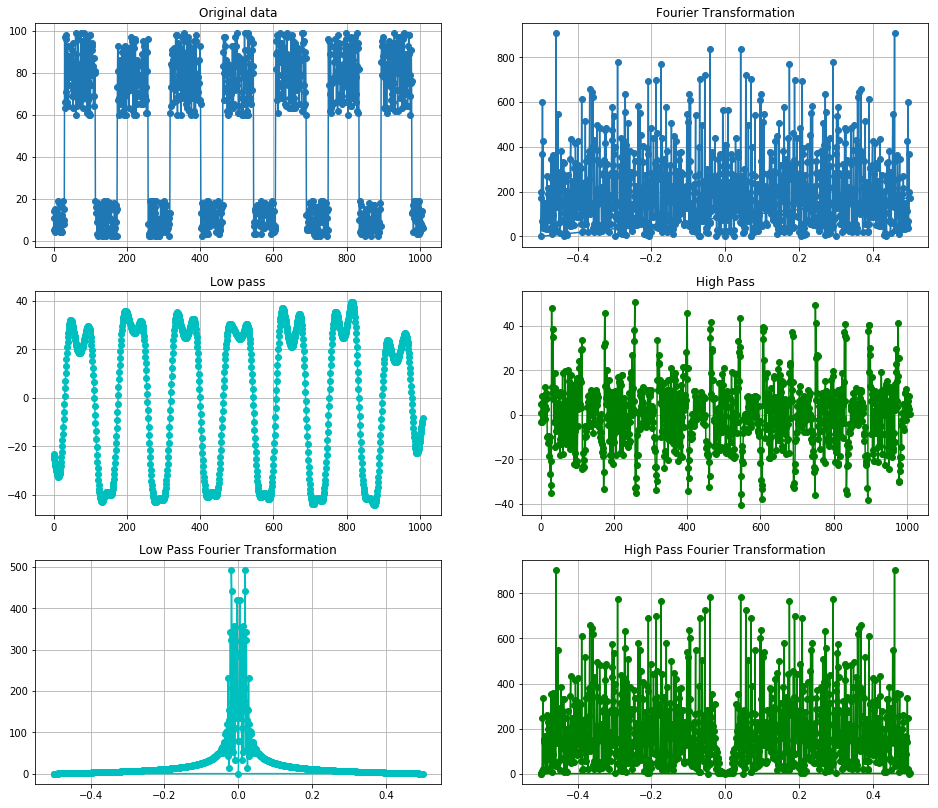

In [272]:
from scipy import signal  
import matplotlib.pyplot as pl
import numpy as np 
import random


NR_SAMPLES_PER_HOUR = 6
# 10 minutes
MINUTES_BETWEEN_SAMPLES = 60 / NR_SAMPLES_PER_HOUR
NR_SAMPLES_PER_DAY = 24 * NR_SAMPLES_PER_HOUR

def get_cpu_stats():
    def create_stats_list(start, stop, hours):
        return [random.randrange(start, stop) for i in range(len(hours) * NR_SAMPLES_PER_HOUR)]
    stats = []
    hours = range(0, 5)
    stats.extend(create_stats_list(2, 20, hours))
    hours = range(5, 19)
    stats.extend(create_stats_list(60, 100, hours))
    hours = range(19, 24)
    stats.extend(create_stats_list(2, 20, hours))
    
    return stats

    # add noise
    for i in range(10):
        x = random.randrange(0, 24*NR_SAMPLES_PER_HOUR)
        if stats[x] > 40:
            stats[x] = random.randrange(2, 10)
        else:
            stats[x] = random.randrange(80, 100)
    return stats

y = []
days = 7
for day in range(days):
    y.extend(get_cpu_stats())
x = np.arange(len(y))

##################################################
pl.figure(figsize=(16,14))


pl.subplot(321)  
pl.plot(x,y, marker='o')  
pl.title('Original data')  
pl.axis('tight')  
pl.grid(which='both', axis='both')

freq = np.fft.fftfreq(x.shape[-1])

imag = abs(np.fft.fft(y).imag)
pl.subplot(322) 
pl.plot(freq, imag, marker = 'o')
pl.title('Fourier Transformation')
pl.axis('tight')
pl.grid(which='both', axis='both')

##################################################

#b,a = signal.butter(3,0.05,'lowpass')
b,a = signal.iirfilter(3,[0.01,0.05],'lowpass')
sf_low = signal.filtfilt(b,a,y)

pl.subplot(323)  
pl.plot(x,sf_low, marker='o', color='c')  
pl.title('Low pass') 
pl.axis('tight')  
pl.grid(which='both', axis='both')

#b,a = signal.butter(3,0.05,'highpass')
b,a = signal.iirfilter(3,[0.05,0.99],'highpass')
sf_high = signal.filtfilt(b,a,y)  
  
pl.subplot(324)  
pl.plot(x,sf_high, marker='o', color='g')
pl.title('High Pass') 
pl.axis('tight')
pl.grid(which='both', axis='both')

##################################################

imag = abs(np.fft.fft(sf_low).imag)
pl.subplot(325) 
pl.plot(freq, imag, marker = 'o', color='c')
pl.title('Low Pass Fourier Transformation') 
pl.axis('tight') 
pl.grid(which='both', axis='both')

imag = abs(np.fft.fft(sf_high).imag)
pl.subplot(326) 
pl.plot(freq, imag, marker = 'o', color='g')
pl.title('High Pass Fourier Transformation') 
pl.axis('tight')
pl.grid(which='both', axis='both')

pl.show()

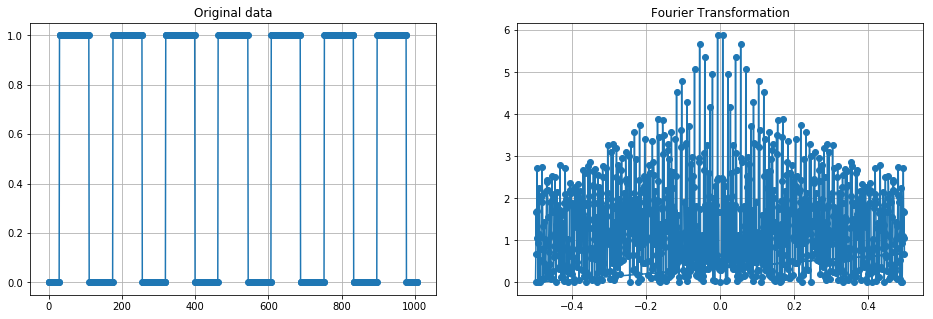

In [273]:
#y = [1 if a > 40 else 0 for a in sf_low] #butter
y = [1 if a > 0 else 0 for a in sf_low] #iirfilter

pl.figure(figsize=(16,5))
pl.subplot(121)  
pl.plot(x,y, marker='o')  
pl.title('Original data')  
pl.axis('tight')  
pl.grid(which='both', axis='both')

freq = np.fft.fftfreq(x.shape[-1])

imag = abs(np.fft.fft(y).imag)
pl.subplot(122) 
pl.plot(freq, imag, marker = 'o')
pl.title('Fourier Transformation')
pl.axis('tight')
pl.grid(which='both', axis='both')

pl.show()

In [275]:
def collect_idle_time_windows(stats):
    time_windows = {}
    nr_idle = 0
    for index, value in enumerate(stats):
        if value == 0:
            nr_idle += 1
        else:
            if nr_idle > 0:
                # key: start sample index
                # value: number of idle samples
                time_windows[index - nr_idle] = nr_idle
                nr_idle = 0
    else:
        if nr_idle > 0:
            time_windows[index - nr_idle] = nr_idle
    # sort by value from max to min
    # returns: [(k1,v1), (k2,v2), ...]
    return sorted(time_windows.items(), key=lambda item: item[1], reverse=True)

def show_idle_time_windows(idle_time_window):
    print("\nidle time windows details:")
    for t in idle_time_window:
        start_day = int(t[0] / NR_SAMPLES_PER_DAY)
        end_day = start_day
        t0 = t[0] % NR_SAMPLES_PER_DAY
        t1 = t[1]
        start_hour = int(t0 / NR_SAMPLES_PER_HOUR)
        start_minute = (t0 % NR_SAMPLES_PER_HOUR) * MINUTES_BETWEEN_SAMPLES
        end_hour = int((t0 + t1) / NR_SAMPLES_PER_HOUR)
        if end_hour > 23:
            end_hour = end_hour - 24
            end_day = start_day + 1
        end_minute = ((t0 + t1) % NR_SAMPLES_PER_HOUR) * MINUTES_BETWEEN_SAMPLES
        print("day[{:>2d}] {:>02d}:{:>02d} ~ day[{:>2d}] {:>02d}:{:>02d} -> {:<3d} minutes".format
              (start_day, start_hour, start_minute, end_day, end_hour, end_minute, MINUTES_BETWEEN_SAMPLES * t1))
        


time_windows = collect_idle_time_windows(y)
print("idle time windows: len={}, data={}".format(len(time_windows), time_windows))
show_idle_time_windows(time_windows)

print("----------")

time_windows.sort()
print("idle time windows: len={}, data={}".format(len(time_windows), time_windows))
show_idle_time_windows(time_windows)

idle time windows: len=8, data=[(111, 65), (688, 65), (256, 64), (833, 64), (545, 63), (400, 63), (976, 31), (0, 30)]

idle time windows details:
day[ 0] 18:30 ~ day[ 1] 05:20 -> 650 minutes
day[ 4] 18:40 ~ day[ 5] 05:30 -> 650 minutes
day[ 1] 18:40 ~ day[ 2] 05:20 -> 640 minutes
day[ 5] 18:50 ~ day[ 6] 05:30 -> 640 minutes
day[ 3] 18:50 ~ day[ 4] 05:20 -> 630 minutes
day[ 2] 18:40 ~ day[ 3] 05:10 -> 630 minutes
day[ 6] 18:40 ~ day[ 6] 23:50 -> 310 minutes
day[ 0] 00:00 ~ day[ 0] 05:00 -> 300 minutes
----------
idle time windows: len=8, data=[(0, 30), (111, 65), (256, 64), (400, 63), (545, 63), (688, 65), (833, 64), (976, 31)]

idle time windows details:
day[ 0] 00:00 ~ day[ 0] 05:00 -> 300 minutes
day[ 0] 18:30 ~ day[ 1] 05:20 -> 650 minutes
day[ 1] 18:40 ~ day[ 2] 05:20 -> 640 minutes
day[ 2] 18:40 ~ day[ 3] 05:10 -> 630 minutes
day[ 3] 18:50 ~ day[ 4] 05:20 -> 630 minutes
day[ 4] 18:40 ~ day[ 5] 05:30 -> 650 minutes
day[ 5] 18:50 ~ day[ 6] 05:30 -> 640 minutes
day[ 6] 18:40 ~ day[ 6